In [613]:
#Team 1
#Time Series Data

# Importing necessary libraries
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.stats import jarque_bera
import warnings

# Configurations
warnings.filterwarnings('ignore')  # Ignoring warnings for cleaner output

In [614]:
# Loading the dataset
df = pd.read_csv('CO2_USA.csv')
df.head(5)  # Displaying the first 5 rows of the dataset

Country  Year  CO2_emission  CO2_emission_pre  Population    Density  \
0  United States  1961  1.220000e+11      119000000000   183691000  19.598703   
1  United States  1962  1.250000e+11      122000000000   186538000  19.902460   
2  United States  1963  1.280000e+11      125000000000   189242000  20.190961   
3  United States  1964  1.310000e+11      128000000000   191889000  20.473379   
4  United States  1965  1.350000e+11      131000000000   194303000  20.730938   

        Area    GDP  real_GDP  Temperature  
0  9372610.0  562.2    3345.7        51.87  
1  9372610.0  603.9    3550.7        51.90  
2  9372610.0  637.5    3705.3        52.26  
3  9372610.0  684.5    3918.8        51.67  
4  9372610.0  742.3    4173.4        51.69

In [615]:
# Because of the wide variance in values, we need to scale as OLS may be affected.
# Min-max scale data due to widely varying values
def minmaxscale(df):
  # Min-max scale data due to widely varying values
  df_scaled = (df - df.min()) / (df.max() - df.min())
  return df_scaled

def z_score_scaling(df):
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
  return scaled_df

# Preprocessing data for regression analysis

# Original Independent values - Dropped CO2 of previous year
X0 = df[['Density', 'real_GDP', 'Temperature', 'CO2_emission_pre']]

# Time
X_time = df[["Year"]]

# Dependent variable
y = df['CO2_emission']

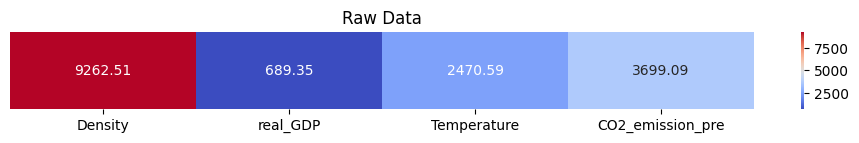

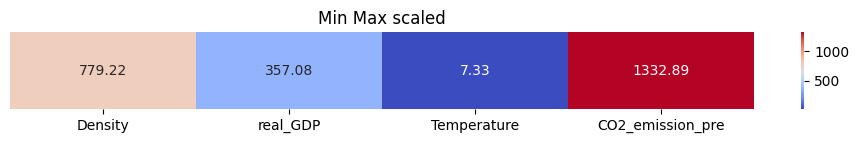

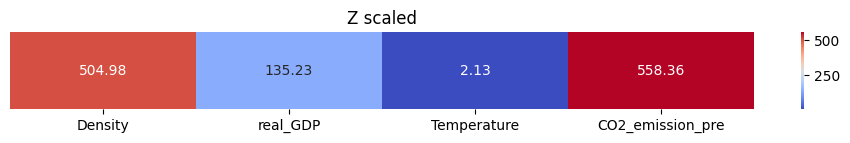

In [616]:
def VIF_heatmap(df, title):
  # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    # Create a heatmap matrix of the VIF values
    vif_matrix = np.array(vif_data['VIF']).reshape(1, -1)
    plt.figure(figsize=(12, 1))
    sns.heatmap(vif_matrix, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=vif_data['feature'], yticklabels=[])
    plt.title(title)
    plt.show()


# Plot VIF to determine which scaling to use
VIF_heatmap(X0, "Raw Data")

VIF_heatmap(minmaxscale(X0), "Min Max scaled")

VIF_heatmap(z_score_scaling(X0), "Z scaled")

# Z-scaled produces lower VIF

In [617]:
# # Drop CO2_emission_pre because of high multicollinearity
# X0 = df[['Density', 'real_GDP', 'Temperature']]

'''
Note: we considered dropping CO2_emission_pre however ran into a very low BP
test score indicating heteroskedasticity , with R2 going to 0.999. We decided
it was better to leave CO2_pre in rather than the low BP pval, and VIF only change
0.001.
'''
# Add back year and Scaled data using z-score
X_scaled = z_score_scaling(X0)

# Add Constant
X_c = sm.add_constant(X_scaled)

# Combine data with year
X = pd.concat([X_time, X_c], axis=1)

# To test R^2 if we drop
X_sans_density = X.drop(['Density'], axis=1)

In [618]:
# Regression Models and Diagnostics
# OLS Regression
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           CO2_emission   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.169e+05
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          4.93e-125
Time:                        04:52:21   Log-Likelihood:                -1274.8
No. Observations:                  60   AIC:                             2562.
Df Residuals:                      54   BIC:                             2574.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Year              3.433e+08   7.98e+07  

In [619]:
# Regression Models and Diagnostics
# OLS Regression dropped Density
# negligible difference
ols_model_sans = sm.OLS(y, X_sans_density).fit()
print(ols_model_sans.summary())

                            OLS Regression Results                            
Dep. Variable:           CO2_emission   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.828e+05
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          1.60e-126
Time:                        04:52:21   Log-Likelihood:                -1278.5
No. Observations:                  60   AIC:                             2567.
Df Residuals:                      55   BIC:                             2577.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Year              4.903e+08   6.02e+07  

In [620]:
# Weighted Least Squares (WLS) Regression
weights = 1 / df['real_GDP']
wls_model = sm.WLS(y, X, weights=weights).fit()
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:           CO2_emission   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.332e+05
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          5.80e-123
Time:                        04:52:21   Log-Likelihood:                -1278.8
No. Observations:                  60   AIC:                             2570.
Df Residuals:                      54   BIC:                             2582.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Year               3.39e+08   9.04e+07  

In [621]:
#Drop weights and constant
#X_noW = X.drop(["weight"], axis=1)

In [622]:
# Elastic Net Regression with Grid Search
param_grid = {'alpha': [0.1, 1, 10, 100], 'l1_ratio': np.arange(0.0, 1.0, 0.1)}
grid_search = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, cv=5)
grid_search.fit(X_noW, y)
best_model = grid_search.best_estimator_
best_model

ElasticNet(alpha=0.1, l1_ratio=0.9)

In [623]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.9, fit_intercept=False, random_state=0)
elastic_net.fit(X_noW, y)
y_pred_ela = elastic_net.predict(X_noW)
ela_residuals = y - y_pred_ela

feature_names = list(X_noW.columns)
coefficients_with_names = dict(zip(feature_names, coefficients))

coefficients_with_names

{'Year': 4749013931.193319,
 'const': 0.0,
 'Density': 1424826018.1171534,
 'real_GDP': 3149728628.0017915,
 'Temperature': 577811988.1801883,
 'CO2_emission_pre': 1966119714.085889}

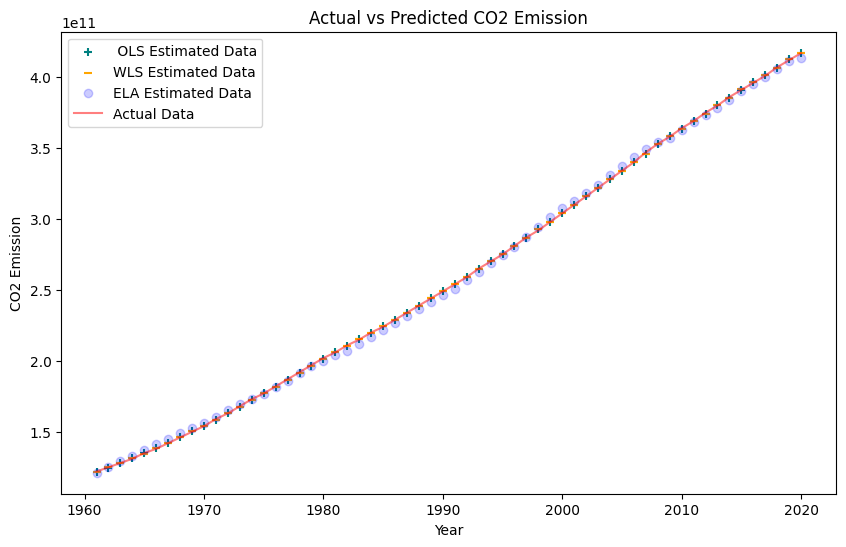

In [624]:
# Predicting the values
y_pred = ols_model.predict(X)
y_pred_wls = wls_model.predict(X)

# Plotting actual vs estimated values
plt.figure(figsize=(10, 6))
#plt.scatter(X['Year'], y, label='Actual Data', marker = 'x', color='red')
plt.scatter(X['Year'], y_pred, label=' OLS Estimated Data', marker = '+', color='teal')
plt.scatter(X['Year'], y_pred_wls, label='WLS Estimated Data', marker = '_', color='orange')
plt.scatter(X['Year'], y_pred_ela, label='ELA Estimated Data', marker = 'o', alpha = 0.2, color='blue')
plt.plot(X['Year'], y, label='Actual Data', alpha = 0.5, color='red')
plt.xlabel('Year')
plt.ylabel('CO2 Emission')
plt.title('Actual vs Predicted CO2 Emission')
plt.legend()
plt.show()

In [625]:
# Get Residuals
ols_residuals = ols_model.resid
wls_residuals = wls_model.resid

In [626]:
# Plot residuals
def plot_residuals(fitted_values, residuals, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(fitted_values, residuals, color='teal', alpha=1, marker="x")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.show()

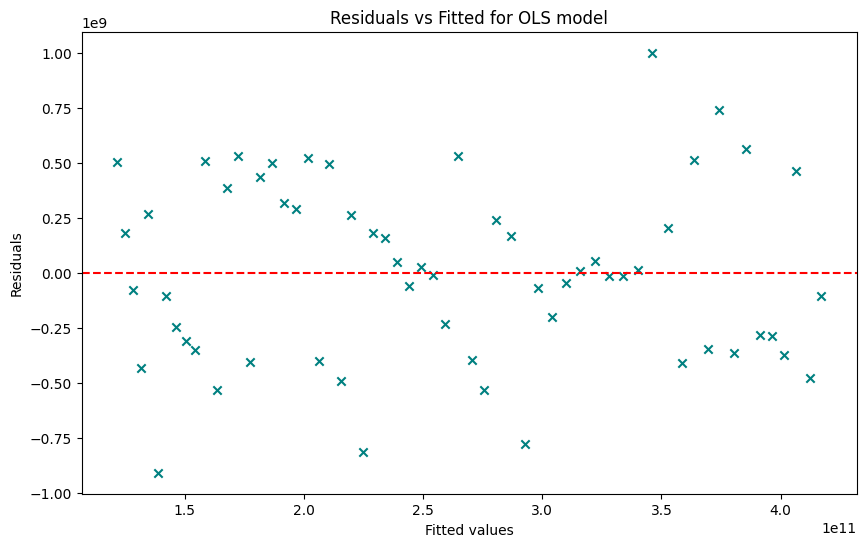

In [627]:
# For OLS
plot_residuals(ols_model.fittedvalues, ols_model.resid, 'Residuals vs Fitted for OLS model')


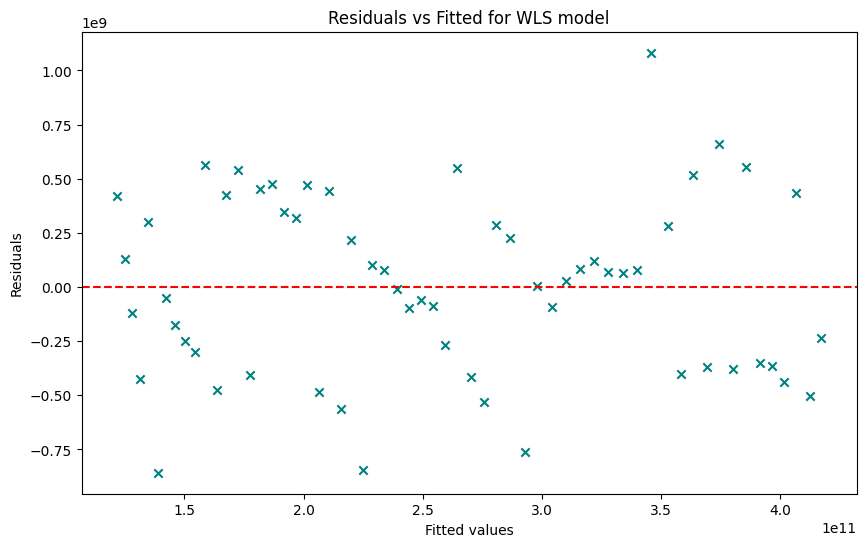

In [628]:
# WLS
plot_residuals(wls_model.fittedvalues, wls_model.resid, 'Residuals vs Fitted for WLS model')

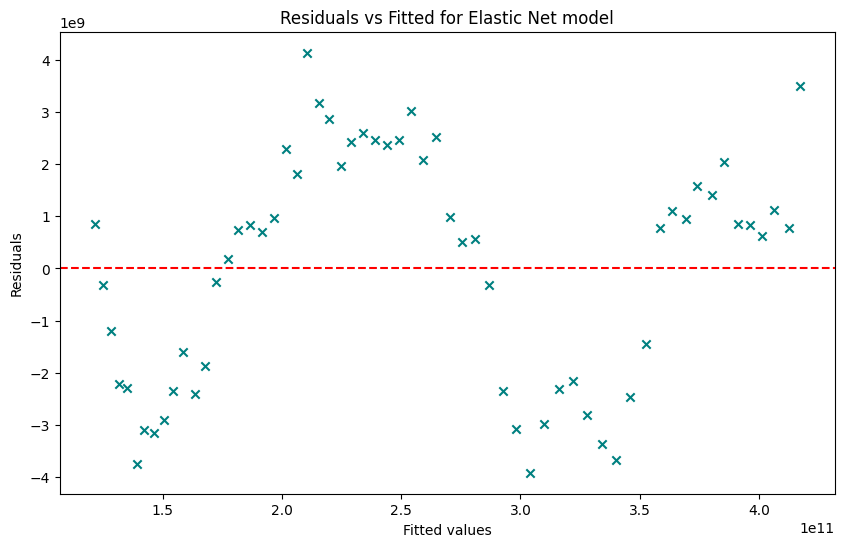

In [629]:
#  Elastic Net model
plot_residuals(y_pred, ela_residuals, 'Residuals vs Fitted for Elastic Net model')

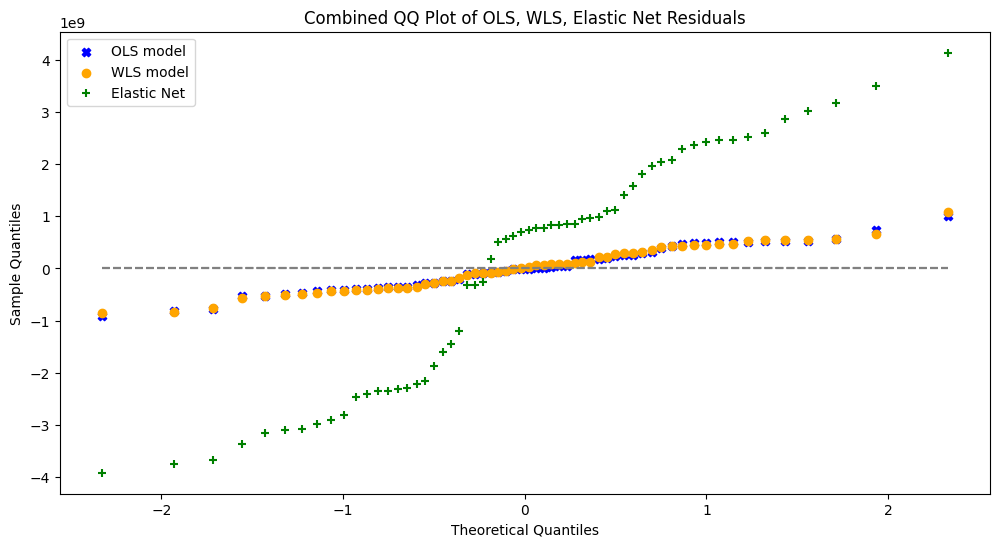

In [630]:
# QQ Plot of resids

def custom_qq_plot(residuals, color, marker, label, ax):
# Calculating quantiles of the residuals
    res_quantiles = np.percentile(residuals, q=np.linspace(0, 100, num=len(residuals)))

    # Calculating the corresponding quantiles of a standard normal distribution
    norm_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, num=len(res_quantiles)))

    # Plotting the quantiles
    ax.scatter(norm_quantiles, res_quantiles, color=color, marker=marker, label=label)
    ax.plot(norm_quantiles, norm_quantiles, color='gray', linestyle='--')  # Line for comparison

# Creating a new plot with custom Q-Q plots for each model
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Custom Q-Q plot for each model
custom_qq_plot(ols_model.resid, color='blue', marker='X', label='OLS model', ax=ax)
custom_qq_plot(wls_model.resid, color='orange', marker = 'o', label='WLS model', ax=ax)
custom_qq_plot(ela_residuals, color='green', marker='+', label='Elastic Net', ax=ax)

plt.title('Combined QQ Plot of OLS, WLS, Elastic Net Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
plt.show()


In [631]:
#JB test
from scipy.stats import jarque_bera
ols_jb_statistic, ols_p_value = jarque_bera(ols_residuals)
print(f"JB Statistic OLS: {ols_jb_statistic}, P-value: {ols_p_value}")
#The ols_residuals is normally distributed
wls_jb_statistic, wls_p_value = jarque_bera(wls_residuals)
print(f"JB Statistic WLS: {wls_jb_statistic}, P-value: {wls_p_value}")
#The wls_residuals is normally distributed
ela_jb_statistic, ela_p_value = jarque_bera(ela_residuals)
print(f"JB Statistic ELA: {ela_jb_statistic}, P-value: {ela_p_value}")
#The ela_residuals is normally distributed

JB Statistic OLS: 0.7521740491953242, P-value: 0.6865425843503548
JB Statistic WLS: 0.7118031996789302, P-value: 0.7005415502448402
JB Statistic ELA: 4.133459974172061, P-value: 0.1265990862280492


In [632]:
# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

           Variable           VIF
0              Year  6.184651e+02
1             const  8.170318e+06
2           Density  9.833659e+02
3          real_GDP  2.877749e+02
4       Temperature  2.144247e+00
5  CO2_emission_pre  7.883631e+02


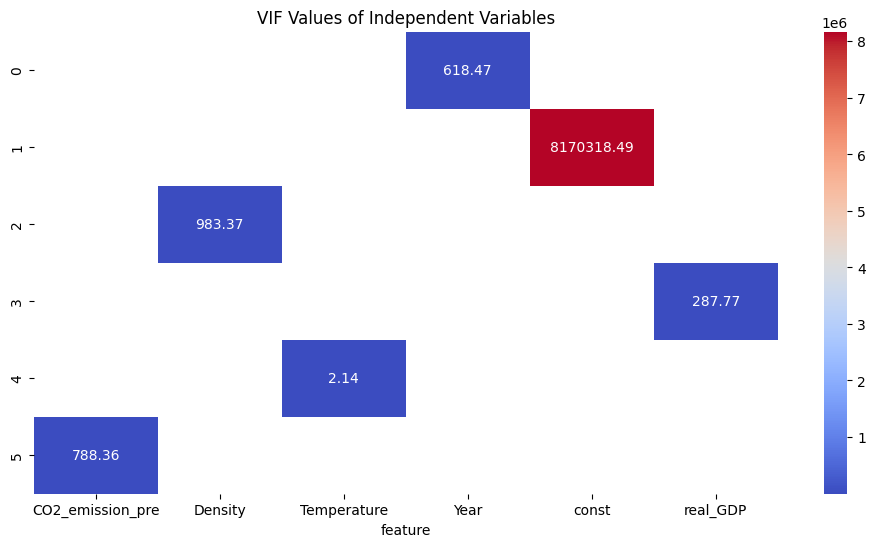

In [633]:
def VIF_heatmap(df, title):
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    # Create a heatmap matrix of the VIF values
    vif_matrix = vif_data.pivot(index=None, columns='feature', values='VIF')

    plt.figure(figsize=(12, 6))
    sns.heatmap(vif_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

VIF_heatmap(X, "VIF Values of Independent Variables")


In [634]:
#BP test
from statsmodels.stats.diagnostic import het_breuschpagan
ols_bp = het_breuschpagan(ols_residuals, ols_model.model.exog)
print(f"BP Statistic OLS: {ols_bp[0]}, P-value: {ols_bp[1]}")
#OLS have no evidence of heteroscedasticity
wls_bp = het_breuschpagan(wls_residuals, wls_model.model.exog)
print(f"BP Statistic WLS: {wls_bp[0]}, P-value: {wls_bp[1]}")
#WLS have no evidence of heteroscedasticity
ela_bp = het_breuschpagan(ela_residuals, X)
print(f"BP Statistic ELA: {ela_bp[0]}, P-value: {ela_bp[1]}")
#Elastic have no evidence of heteroscedasticity

BP Statistic OLS: 1.3926958859491578, P-value: 0.9251105939871255
BP Statistic WLS: 1.1081747264848651, P-value: 0.9533775415144444
BP Statistic ELA: 8.751219411563287, P-value: 0.11940818856024989


In [635]:
# Calculating the Durbin-Watson statistic
from statsmodels.stats.stattools import durbin_watson
ols_dw_statistic = durbin_watson(ols_residuals)
print(f"Durbin-Watson Statistic OLS: {ols_dw_statistic}")
#OLS have negative autocorrelation
wls_dw_statistic = durbin_watson(wls_residuals)
print(f"Durbin-Watson Statistic WLS: {wls_dw_statistic}")
#WLS have negative autocorrelation
ela_dw_stat = durbin_watson(ela_residuals)
print(f"Durbin-Watson statistic ELA: {ela_dw_stat}")
#Elastic have negative autocorrelation

Durbin-Watson Statistic OLS: 2.541103031009389
Durbin-Watson Statistic WLS: 2.516946538899115
Durbin-Watson statistic ELA: 0.17215814790535358


In [636]:
# White has issues due to the high multicolinearity, lets try removing one of the indeps:

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF
vif_df = calculate_vif(X_scaled)

# Checking VIF values
#vif_df

# Density to reduce multicollinearity
X_scaled_reduced = X_scaled.drop(['CO2_emission_pre'], axis=1)
X_reduced = pd.concat([X_time, sm.add_constant(X_scaled_reduced)], axis=1)
X_noW_reduced = X_reduced.drop(['Year'], axis=1)  # For Elastic Net

# Recalculate VIF for the reduced set of features
vif_df_reduced = calculate_vif(X_scaled_reduced)

# Refitting the models with reduced features
# OLS Regression
ols_model_reduced = sm.OLS(y, X_reduced).fit()
ols_residuals_reduced = ols_model_reduced.resid

# WLS Regression
wls_model_reduced = sm.WLS(y, X_reduced, weights=weights).fit()
wls_residuals_reduced = wls_model_reduced.resid

# Elastic Net Regression
elastic_net_reduced = ElasticNet(alpha=1, l1_ratio=0.8, random_state=0)
elastic_net_reduced.fit(X_noW_reduced, y)
y_pred_ela_reduced = elastic_net_reduced.predict(X_noW_reduced)
ela_residuals_reduced = y - y_pred_ela_reduced

# Perform White's test for the reduced models
ols_white_test_reduced = het_white(ols_residuals_reduced, ols_model_reduced.model.exog)
wls_white_test_reduced = het_white(wls_residuals_reduced, wls_model_reduced.model.exog)
ela_white_test_reduced = het_white(ela_residuals_reduced, X_noW_reduced)

# Results
print("White Test Results:")
print("\nOLS Model:")
print(f"Test Statistic: {ols_white_test_reduced[0]}")
print(f"P-value: {ols_white_test_reduced[1]}")

print("\nWLS Model:")
print(f"Test Statistic: {wls_white_test_reduced[0]}")
print(f"P-value: {wls_white_test_reduced[1]}")

print("\nElastic Net Model:")
print(f"Test Statistic: {ela_white_test_reduced[0]}")
print(f"P-value: {ela_white_test_reduced[1]}")




White Test Results:

OLS Model:
Test Statistic: 32.66158215092277
P-value: 0.0032227333734048155

WLS Model:
Test Statistic: 28.18028269846488
P-value: 0.01346393795914392

Elastic Net Model:
Test Statistic: 51.269422294491946
P-value: 6.211296246196342e-08


In [637]:
#Back testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_backtest = X
X_backtest['weight'] = 1 / df['real_GDP']
X_train, X_test, y_train, y_test = train_test_split(X_backtest,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)
weights_train = X_train['weight']

# Preparing datasets
X_train = X_train.drop('weight', axis=1)
X_test = X_test.drop('weight', axis=1)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# OLS model
ols_model_b_t = sm.OLS(y_train, X_train_const).fit()
ols_mse = mean_squared_error(y_test, ols_model_b_t.predict(X_test_const))
print(f"Mean Squared Error of OLS: {ols_mse}")

# WLS model
wls_model_b_t = sm.WLS(y_train, X_train_const, weights=weights_train).fit()
wls_mse = mean_squared_error(y_test, wls_model_b_t.predict(X_test_const))
print(f"Mean Squared Error of WLS: {wls_mse}")

# Elastic Net model
elastic_net_b_t = ElasticNet(alpha=1, l1_ratio=0.8, random_state=0)
elastic_net_b_t.fit(X_train, y_train)
ela_mse = mean_squared_error(y_test, elastic_net_b_t.predict(X_test))
print(f"Mean Squared Error of Elastic Net: {ela_mse}")


Mean Squared Error of OLS: 1.7153355868120563e+17
Mean Squared Error of WLS: 1.9805868724640026e+17
Mean Squared Error of Elastic Net: 3.164124865162773e+19


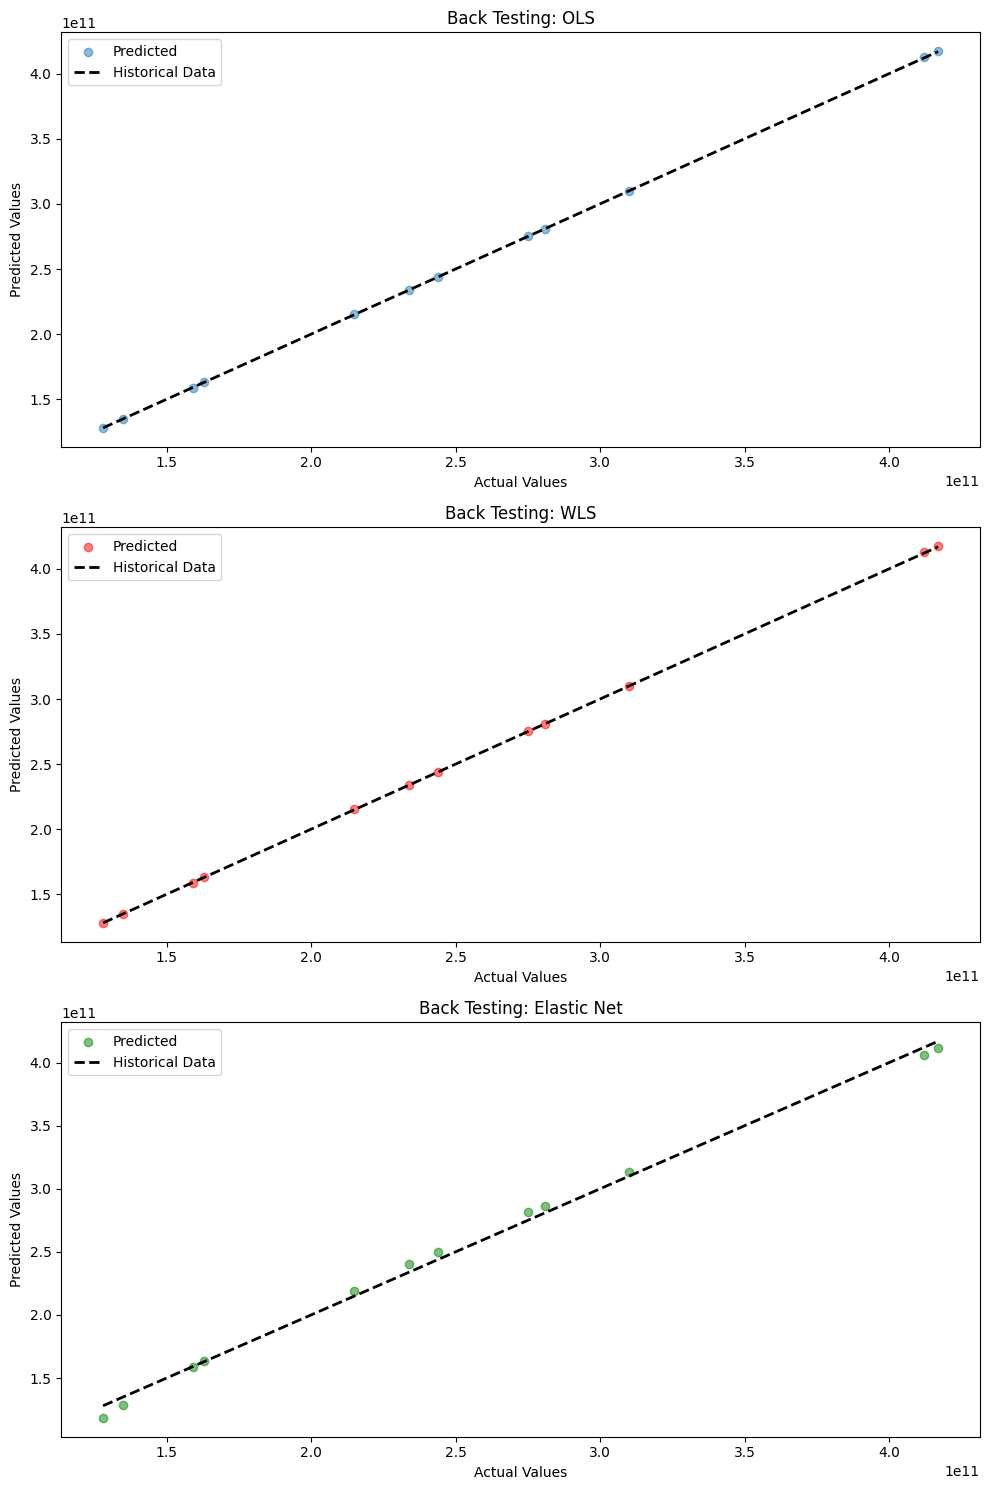

In [638]:
# Generate predictions for each model
ols_predictions = ols_model_b_t.predict(X_test_const)
wls_predictions = wls_model_b_t.predict(X_test_const)
ela_predictions = elastic_net_b_t.predict(X_test)

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for OLS
axs[0].scatter(y_test, ols_predictions, alpha=0.5, label='Predicted')
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Historical Data')
axs[0].set_title('Back Testing: OLS')
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].legend()

# Plot for WLS
axs[1].scatter(y_test, wls_predictions, alpha=0.5, color='r', label='Predicted')
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Historical Data')
axs[1].set_title('Back Testing: WLS')
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].legend()

# Plot for Elastic Net
axs[2].scatter(y_test, ela_predictions, alpha=0.5, color='g', label='Predicted')
axs[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Historical Data')
axs[2].set_title('Back Testing: Elastic Net')
axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].legend()

# Display the plot
plt.tight_layout()
plt.show()

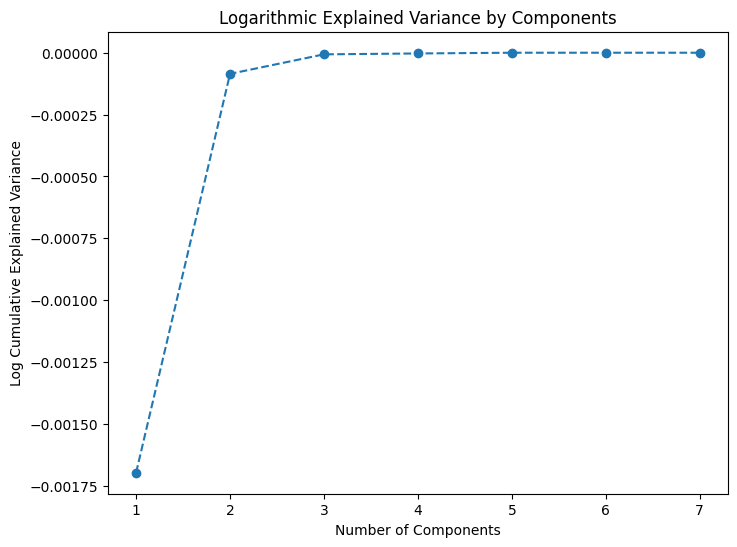

In [639]:
# BONUS PCS +. OLS
# Applying PCA to the scaled data
pca_scaled = PCA().fit(X)

# Plotting the Explained Variance with a logarithmic scale
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_scaled.explained_variance_ratio_) + 1),
         np.log(pca_scaled.explained_variance_ratio_.cumsum()),
         marker='o', linestyle='--')
plt.title('Logarithmic Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Log Cumulative Explained Variance')
plt.show()

# Choose number of components based on plot
n_components = 2  # Example, adjust based on analysis
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# OLS Regression using PCA Components
y = df['CO2_emission']
X_pca_sm = sm.add_constant(X_pca)
ols_model_pca = sm.OLS(y, X_pca_sm).fit()

# Function to plot residuals
def plot_residuals(model, title):
    residuals = model.resid
    fitted = model.fittedvalues
    plt.scatter(fitted, residuals)
    plt.axhline(y=0, linestyle='--', color='black')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.show()


In [640]:
# Regression summary for the OLS model with PCA components
ols_model_pca_summary = ols_model_pca.summary()
print(ols_model_pca_summary)

                            OLS Regression Results                            
Dep. Variable:           CO2_emission   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.584e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           4.98e-85
Time:                        04:52:25   Log-Likelihood:                -1393.8
No. Observations:                  60   AIC:                             2794.
Df Residuals:                      57   BIC:                             2800.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.589e+11   3.93e+08    658.771      0.0

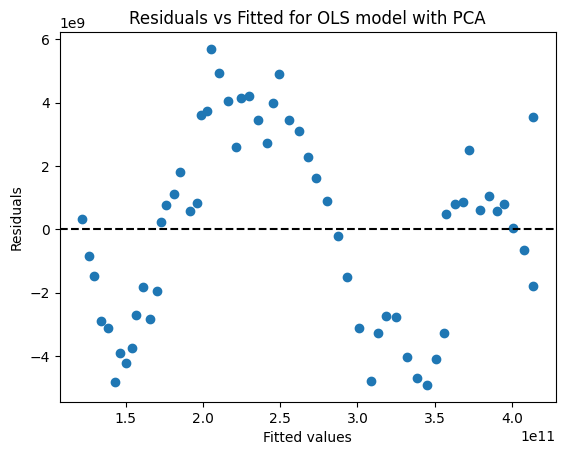

0.9988984726654806

In [641]:
# Plot residuals for the OLS model
plot_residuals(ols_model_pca, 'Residuals vs Fitted for OLS model with PCA')

# Print R-squared value
ols_model_pca.rsquared

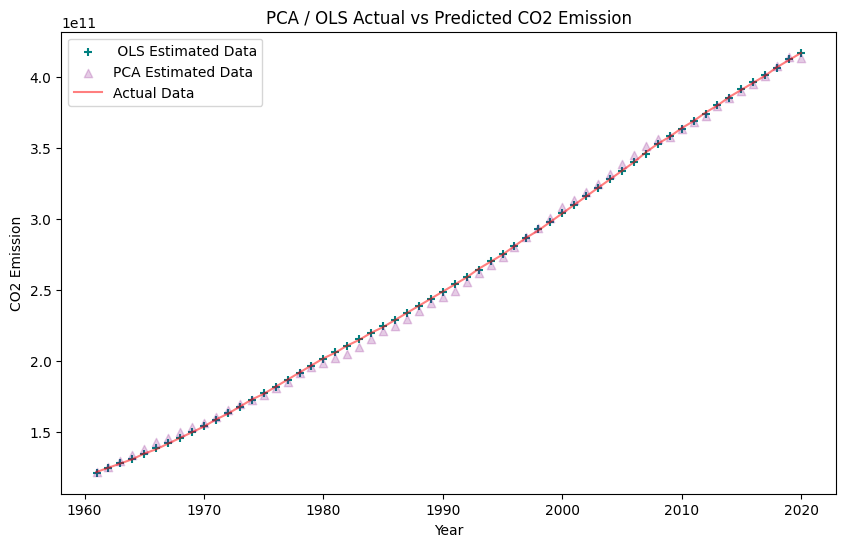

In [642]:
# Predicting the values
y_pred_PCA = ols_model_pca.predict(X_pca_sm)

# Plotting actual vs estimated values
plt.figure(figsize=(10, 6))
#plt.scatter(X['Year'], y, label='Actual Data', marker = 'x', color='red')
plt.scatter(X['Year'], y_pred, label=' OLS Estimated Data', marker = '+', color='teal')
plt.scatter(X['Year'], y_pred_PCA, label='PCA Estimated Data', marker = '^', alpha = 0.2, color='purple')
plt.plot(X['Year'], y, label='Actual Data', alpha = 0.5, color='red')
plt.xlabel('Year')
plt.ylabel('CO2 Emission')
plt.title('PCA / OLS Actual vs Predicted CO2 Emission')
plt.legend()
plt.show()

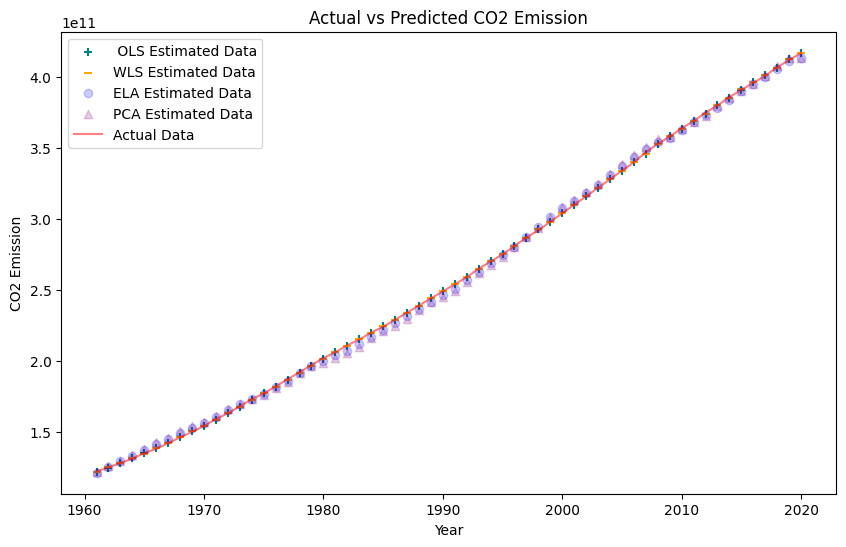

In [643]:
# Predicting the values
y_pred_PCA = ols_model_pca.predict(X_pca_sm)

# Plotting actual vs estimated values
plt.figure(figsize=(10, 6))
#plt.scatter(X['Year'], y, label='Actual Data', marker = 'x', color='red')
plt.scatter(X['Year'], y_pred, label=' OLS Estimated Data', marker = '+', color='teal')
plt.scatter(X['Year'], y_pred_wls, label='WLS Estimated Data', marker = '_', color='orange')
plt.scatter(X['Year'], y_pred_ela, label='ELA Estimated Data', marker = 'o', alpha = 0.2, color='blue')
plt.scatter(X['Year'], y_pred_PCA, label='PCA Estimated Data', marker = '^', alpha = 0.2, color='purple')
plt.plot(X['Year'], y, label='Actual Data', alpha = 0.5, color='red')
plt.xlabel('Year')
plt.ylabel('CO2 Emission')
plt.title('Actual vs Predicted CO2 Emission')
plt.legend()
plt.show()

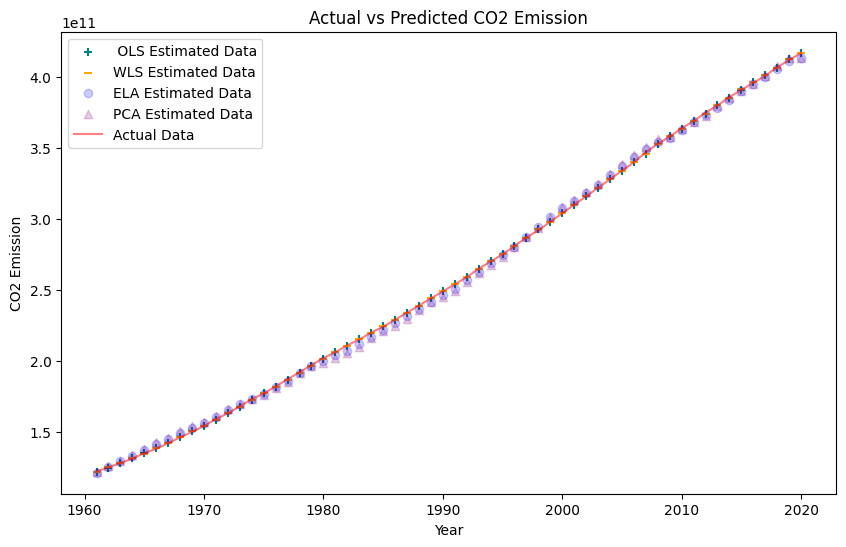

In [644]:
# Plotting actual vs estimated values
plt.figure(figsize=(10, 6))
#plt.scatter(X['Year'], y, label='Actual Data', marker = 'x', color='red')
plt.scatter(X['Year'], y_pred, label=' OLS Estimated Data', marker = '+', color='teal')
plt.scatter(X['Year'], y_pred_wls, label='WLS Estimated Data', marker = '_', color='orange')
plt.scatter(X['Year'], y_pred_ela, label='ELA Estimated Data', marker = 'o', alpha = 0.2, color='blue')
plt.scatter(X['Year'], y_pred_PCA, label='PCA Estimated Data', marker = '^', alpha = 0.2, color='purple')
plt.plot(X['Year'], y, label='Actual Data', alpha = 0.5, color='red')
plt.xlabel('Year')
plt.ylabel('CO2 Emission')
plt.title('Actual vs Predicted CO2 Emission')
plt.legend()
plt.show()